In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

2023-04-30 16:16:51.359008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 16:16:51.428614: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# For reproducibility purposes
np.random.seed(42)

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda y: librosa.feature.melspectrogram(y=y, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))


In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    #song_samples = 660000
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        temp_file_list = os.listdir(folder)
        for file in temp_file_list:
          file_name = folder + "/" + file
          arr_fn.append(file_name)
          arr_genres.append(genres[x])
          
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [8]:
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# gtzan_dir = '/content/drive/MyDrive/Music_Genre_Classification/data/genres/'          

# Prjwal's computer 
gtzan_dir = '/home/bhuyan2/ECE_539/data/genres/'

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27261, 128, 129, 1) (11700, 128, 129, 1) (27261, 10) (11700, 10)


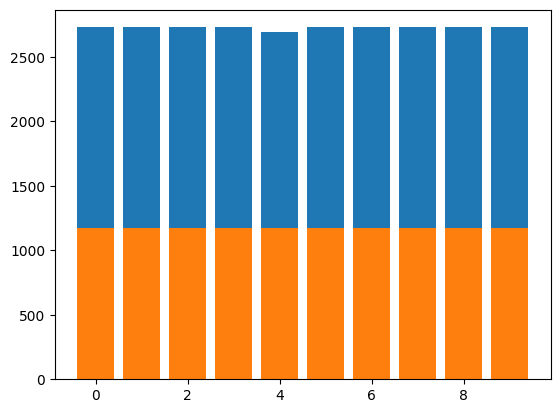

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [11]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [12]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [13]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    
    # Global Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [14]:
model = create_model(X_train[0].shape, len(genres))

2023-04-30 16:36:12.709111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 129, 16)      160       
                                                                 
 activation (Activation)     (None, 128, 129, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                             

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [18]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [19]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=150,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/150


/tmp/ipykernel_2082373/994739274.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


213/213 [==============================] - 30s 133ms/step - loss: 13.1992 - accuracy: 0.1726 - val_loss: 6.7078 - val_accuracy: 0.1957 - lr: 0.0010
Epoch 2/150
213/213 [==============================] - 23s 106ms/step - loss: 4.9453 - accuracy: 0.1599 - val_loss: 3.7807 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 3/150
213/213 [==============================] - 18s 84ms/step - loss: 3.2068 - accuracy: 0.1949 - val_loss: 2.7881 - val_accuracy: 0.2028 - lr: 0.0010
Epoch 4/150
213/213 [==============================] - 18s 85ms/step - loss: 2.6080 - accuracy: 0.2106 - val_loss: 2.4360 - val_accuracy: 0.1824 - lr: 0.0010
Epoch 5/150
213/213 [==============================] - 18s 84ms/step - loss: 2.3479 - accuracy: 0.2071 - val_loss: 2.2698 - val_accuracy: 0.2366 - lr: 0.0010
Epoch 6/150
213/213 [==============================] - 20s 92ms/step - loss: 2.2826 - accuracy: 0.2177 - val_loss: 2.1939 - val_accuracy: 0.2407 - lr: 0.0010
Epoch 7/150
213/213 [==============================] - 23s 10

213/213 [==============================] - 30s 142ms/step - loss: 1.5878 - accuracy: 0.4773 - val_loss: 1.6487 - val_accuracy: 0.4703 - lr: 8.5737e-04
Epoch 49/150
213/213 [==============================] - 31s 145ms/step - loss: 1.5209 - accuracy: 0.4949 - val_loss: 1.5134 - val_accuracy: 0.5048 - lr: 8.5737e-04
Epoch 50/150
213/213 [==============================] - 30s 141ms/step - loss: 1.4922 - accuracy: 0.5138 - val_loss: 1.6446 - val_accuracy: 0.4800 - lr: 8.5737e-04
Epoch 51/150
213/213 [==============================] - 31s 145ms/step - loss: 1.5419 - accuracy: 0.5108 - val_loss: 1.5966 - val_accuracy: 0.4842 - lr: 8.5737e-04
Epoch 52/150
213/213 [==============================] - 32s 148ms/step - loss: 1.5620 - accuracy: 0.4887 - val_loss: 1.4756 - val_accuracy: 0.5265 - lr: 8.5737e-04
Epoch 53/150
213/213 [==============================] - 31s 144ms/step - loss: 1.5099 - accuracy: 0.5015 - val_loss: 1.8638 - val_accuracy: 0.4254 - lr: 8.5737e-04
Epoch 54/150
213/213 [=======

Epoch 93/150
213/213 [==============================] - 31s 146ms/step - loss: 1.1838 - accuracy: 0.6435 - val_loss: 1.2092 - val_accuracy: 0.6600 - lr: 6.3025e-04
Epoch 94/150
213/213 [==============================] - 31s 144ms/step - loss: 1.1561 - accuracy: 0.6433 - val_loss: 1.3011 - val_accuracy: 0.6041 - lr: 6.3025e-04
Epoch 95/150
213/213 [==============================] - 30s 142ms/step - loss: 1.2005 - accuracy: 0.6447 - val_loss: 1.2163 - val_accuracy: 0.6354 - lr: 6.3025e-04
Epoch 96/150
213/213 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.6334
Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0005987368611386045.
213/213 [==============================] - 30s 142ms/step - loss: 1.1886 - accuracy: 0.6334 - val_loss: 1.2694 - val_accuracy: 0.6269 - lr: 6.3025e-04
Epoch 97/150
213/213 [==============================] - 31s 143ms/step - loss: 1.1580 - accuracy: 0.6548 - val_loss: 1.2015 - val_accuracy: 0.6488 - lr: 5.9874e-04
Epoch 98/150
213/2

213/213 [==============================] - 31s 145ms/step - loss: 0.9533 - accuracy: 0.7197 - val_loss: 1.2239 - val_accuracy: 0.6418 - lr: 4.4013e-04
Epoch 136/150
213/213 [==============================] - 31s 144ms/step - loss: 0.9921 - accuracy: 0.7104 - val_loss: 1.0729 - val_accuracy: 0.6907 - lr: 4.1812e-04
Epoch 137/150
213/213 [==============================] - 31s 144ms/step - loss: 0.9815 - accuracy: 0.7110 - val_loss: 1.1927 - val_accuracy: 0.6422 - lr: 4.1812e-04
Epoch 138/150
213/213 [==============================] - 31s 144ms/step - loss: 1.0476 - accuracy: 0.6951 - val_loss: 1.0768 - val_accuracy: 0.6848 - lr: 4.1812e-04
Epoch 139/150
213/213 [==============================] - ETA: 0s - loss: 0.9403 - accuracy: 0.7215
Epoch 139: ReduceLROnPlateau reducing learning rate to 0.00039721422654110934.
213/213 [==============================] - 31s 146ms/step - loss: 0.9403 - accuracy: 0.7215 - val_loss: 1.0732 - val_accuracy: 0.6916 - lr: 4.1812e-04
Epoch 140/150
213/213 [==

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.051 and val_acc = 0.685


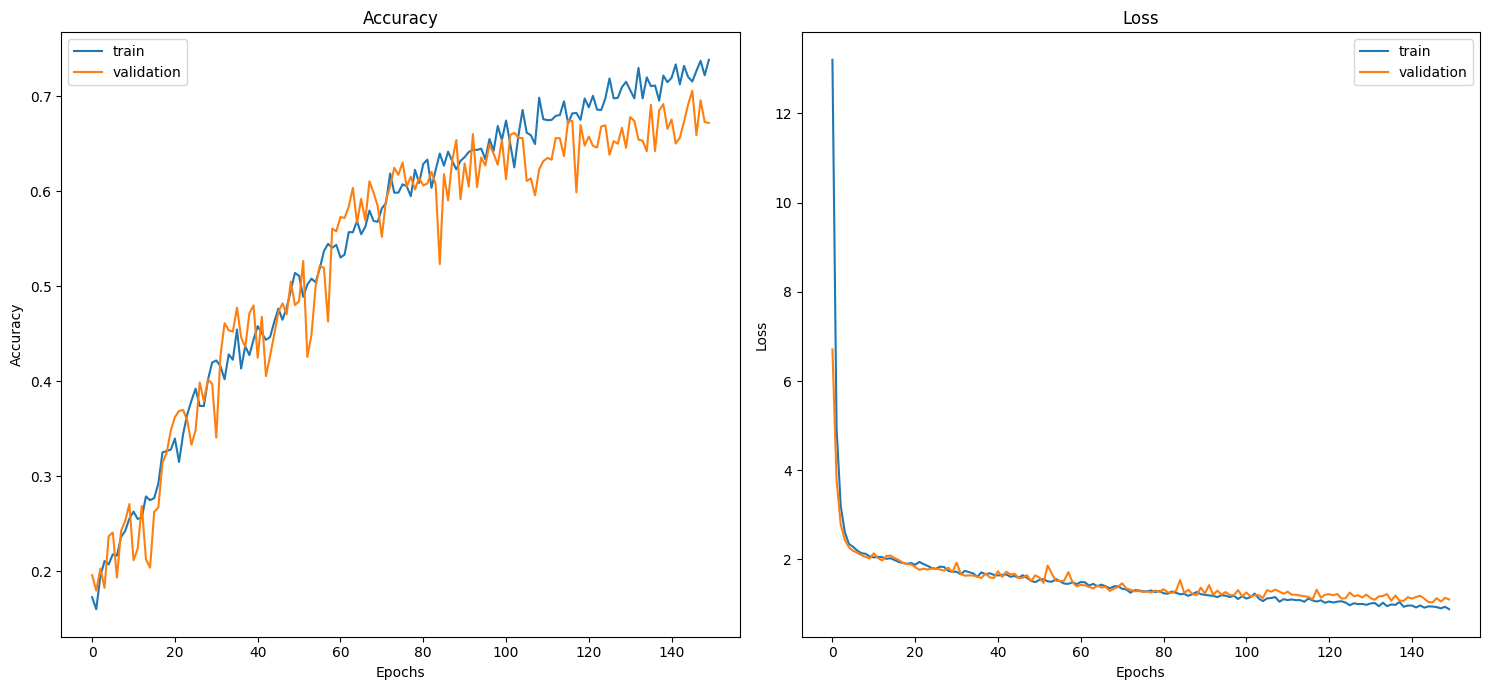

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

366/366 [==============================] - 9s 25ms/step


Normalized confusion matrix


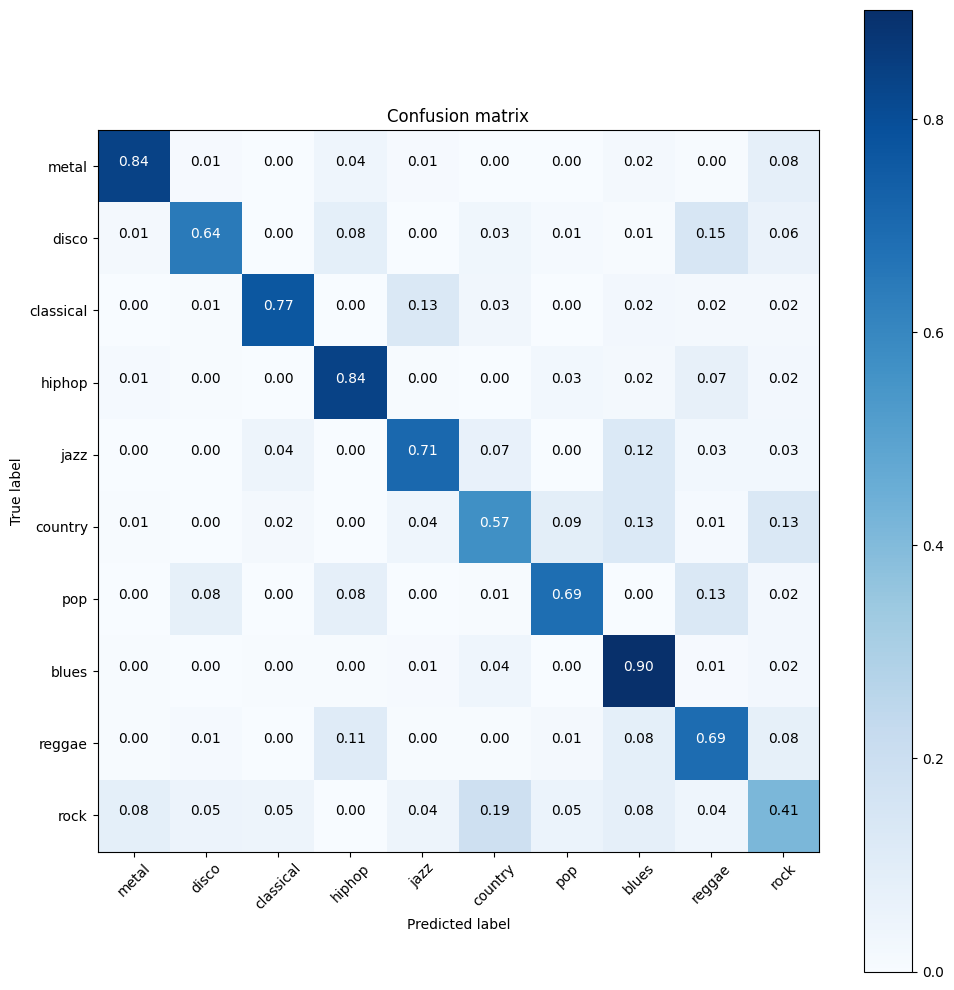

In [24]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

In [25]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [26]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [27]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [28]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [29]:
# from sklearn.metrics import accuracy_score

# print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))
print("precision recall f1 score",precision_recall_fscore_support(label, scores_songs, average='macro'))

majority voting system (acc) = 0.760
precision recall f1 score (0.7817640349846232, 0.76, 0.7598297424580562, None)
